# Agent-based stochastic simulation

We first simulate the stochastic birth and hopping dynamics of a population of agents on a 2D environment with a Gillespie algorithm.

The resource level of each site belongs to one of the five resource levels, [0,1,2,3,4], and each resource level has an associated birth rate, defined in the variable "birth" in the Agent class below. Note the birth rate is a characteristic of the environment so that it is fixed and same for all agents. Typically, the birth rate at each resource level is taken to be [0,1,2,3,4], but we also vary $b_5$, birth rate at the highest resource level, to investigate the transition of the most competititve phenotypes as discussed in the paper. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import pickle
import os
import copy
from concurrent.futures import ProcessPoolExecutor
%autosave 10

Autosaving every 10 seconds


In [2]:
class Agent:
    """
    Agent class encapsulates the information about the position and phenotpye of the agent as well as the agent's current birth and relocation rate.

        Parameters:
            birth (array like): the associated birth rate at each resource level
            hop (array like): relocation rate (a.k.a hopping rate) of the agent at resource levels 1 to 5, which comprises the agent's phenotype
            x, y (int): the x and y coordinate of the agent's location in the 2-dimensional environment
            pos (int,int): the agent's current location
            b (int): the agent's current birth rate
            h (float): the agent's current relocation rate
        Methods:
            updatepos(x,y): update the agent's location to (x,y) and update its current birth and relocation rate accordingly
    """

    def __init__(self, birth, hop, x, y):
        self.birth = tuple(birth)
        self.hop = list(hop)
        self.pos = (x, y)
        # resource goes as 0, 1, 2, 3, 4
        self.b = self.birth[int(resource[x, y])]
        self.h = self.hop[int(resource[x, y])]

    def updatepos(self, x, y):
        self.pos = (x, y)
        # resource goes as 0, 1, 2, 3, 4
        self.b = self.birth[int(resource[x, y])]
        self.h = self.hop[int(resource[x, y])]

    def __str__(self):
        return 'hopping rate {} at location {}'.format(self.hop, self.pos)

    def __repr__(self):
        return 'Agent({},{},{},{})'.format(self.birth, self.hop, *self.pos)


def get_num(a, n):
    """
    Count agent numbers at all the locations

        Parameters: 
            a (array_like): list of agent object;
            n (int): size of the square environment
        Return:
            num (array_like): entry at i,j represents the number of agent at location (i,j)
    """
    num = np.zeros((n, n), dtype=int)
    for pos in [a[i].__dict__['pos'] for i in range(len(a))]:
        num[pos] += 1
    return num


def get_i(x, arr, l, r):
    """
    Binary search for the index of an element in a sorted list

        Parameters:
            x (float): target to be located for
            arr (array_like): a sorted list where the target will be located at
            l (int): left pointer, usually start with 0
            r (int): right pointer, usually start with len(a)
        Return:
            i (int): index of the element so that arr[i]<=x<=arr[i+1]
    """
    if x <= arr[0]:
        return 0
    else:
        while l <= r:
            mid = l + int((r - l)/2)
            # Check if x is present at mid
            if arr[mid] < x and arr[mid+1] >= x:
                return mid+1
            # If x is greater, ignore left half
            elif arr[mid+1] < x:
                l = mid + 1
            # If x is smaller, ignore right half
            else:
                r = mid
        raise Exception("Target not found")


def uniform_resource(x, y):
    """Return a uniformly generated 2-dimensional numpy array representing the resource level at each site"""
    rng = np.random.default_rng()
    return rng.choice([0, 1, 2, 3, 4], size=(x, y))


def exponetial_resource(x, y, c):
    rng = np.random.default_rng()
    p = [np.exp(-i*c) for i in range(5)]
    w = p/np.sum(p)
    return rng.choice([0, 1, 2, 3, 4], size=(x, y), p=w)


def intialcondtiongenerator_uniform(hop_high=10, n=128, m=500, birth=[0, 1, 2, 3, 4]):
    """Generate a list of agents with randomly chosen relocation rates and locations; locations do not repeat
    """
    rng = np.random.default_rng()
    pos = np.array([[i//n, i % n]
                   for i in rng.choice(n*n, m, replace=False)])
    return [Agent(birth, hop, x, y) for hop, x, y in zip(rng.uniform(0, hop_high, (m, 5)), pos[:, 0], pos[:, 1])]

### Implementing Gillespie algorithm for the agent-based model
A natural way of choosing which agent to give birth or relocate is to use np.random.choice() with the normalized rates as the probabilities. A substantial speed-up can be achieved by implementing the binary search algorithm and updating the cumulative sum of the birth or hopping rates sequentially after every event, while each call of the np.random.choice() will calculate the cumulative sum once.


In [3]:
def evolve_gillespie(birth=[0, 1, 2, 3, 4], tot_iter=201, env_size=128, birth_noise=0.05, hop_high=10,
                     save_data=False, trial=0,  save_iter=50, agents=500, duration_iter=0.3, carrying_capacity=1, c=0, simulation_notes=None):
    rng = np.random.default_rng()
    a = intialcondtiongenerator_uniform(
        birth=birth, hop_high=hop_high, n=env_size, m=agents)
    if save_data == True:
        _path = './evolve_data' + \
            '/{}'.format(time.strftime("%Y_%m_%d_%H_%M",
                         time.localtime()))+'/trial_{}'.format(trial)
#         _path = './evolve_data/b5_c_plane'+'/b5_{}_c_{}'.format(birth[-1],c)+'/trial_{}'.format(trial)
#         _path = './evolve_data/noise_std' + '/std_{}_with_agents_number'.format(birth_noise) + '/trial_{}'.format(trial)
        os.makedirs(_path, exist_ok=True)
        info = {"lattice": "{}*{}".format(env_size, env_size), "exponential_coefficient": c, "total_iteartion": tot_iter, "evolve_time": duration_iter, "noise": birth_noise,
                "carrying_capacity": carrying_capacity, "initial_angent_number": agents, "data_stored_every": save_iter, "notes": simulation_notes}
        with open(_path+'/simulation_info.txt', "wb") as fp:
            pickle.dump(info, fp)
        with open(_path+'/resource.txt', "wb") as fp:
            pickle.dump(resource, fp)
        with open(_path+'/iteration_00', "wb") as fp:
            pickle.dump(a, fp)

    for iteration in range(tot_iter):
        t = 0
        num = get_num(a, env_size)
        br = [a[i].b for i in range(len(a))]
        hr = [a[i].h for i in range(len(a))]
        brsum = sum(br)
        tot_rates = brsum + sum(hr)  # total rates

        br_cumsum = np.cumsum(br)
        hr_cumsum = np.cumsum(hr)
        while t < duration_iter:

            dt = -np.log(rng.random()) / tot_rates
            t = t + dt
            r = tot_rates * rng.random()

            if r < brsum:
                # birth
                i = get_i(r, br_cumsum, 0, len(a)-1)
                hop_advance = [[1, 0], [0, 1], [-1, 0],
                               [0, -1]][rng.integers(0, 4)]
                pos_new = (np.array(a[i].pos)+np.array(hop_advance)) % env_size

                if num[pos_new[0], pos_new[1]] < carrying_capacity:
                    noise = rng.normal(0, birth_noise, 5)
                    hop_new = np.clip(np.array(a[i].hop)+noise, 0, hop_high)
                    a.append(Agent(birth, hop_new, pos_new[0], pos_new[1]))
                    num[pos_new[0], pos_new[1]] += 1
                    br.append(a[-1].b)
                    hr.append(a[-1].h)
                    brsum += a[-1].b
                    tot_rates += a[-1].b+a[-1].h
                    br_cumsum = np.append(br_cumsum, a[-1].b+br_cumsum[-1])
                    hr_cumsum = np.append(hr_cumsum, a[-1].h+hr_cumsum[-1])

            else:
                # hopping
                i = get_i(r, brsum+hr_cumsum, 0, len(a)-1)
                hop_advance = [[1, 0], [0, 1], [-1, 0],
                               [0, -1]][rng.integers(0, 4)]
                pos_new = (np.array(a[i].pos)+np.array(hop_advance)) % env_size

                if num[pos_new[0], pos_new[1]] < carrying_capacity:
                    num[pos_new[0], pos_new[1]] += 1
                    num[a[i].pos[0], a[i].pos[1]] -= 1
                    a[i].updatepos(pos_new[0], pos_new[1])
                    brsum += a[i].b-br[i]
                    tot_rates += a[i].b-br[i]+a[i].h-hr[i]
                    br_cumsum[i:] += a[i].b-br[i]
                    hr_cumsum[i:] += a[i].h-hr[i]
                    br[i] = a[i].b
                    hr[i] = a[i].h

        if len(a) > agents:
            # bring back the population back to its initial size
            reset = rng.choice(len(a), agents, replace=False)
            a = [a[i] for i in reset]
        if save_data == True:
            if iteration % save_iter == 0:
                with open(_path+'/iteration_{}'.format(iteration), "wb") as fp:
                    pickle.dump(a, fp)

    return a

### Multiprocessing

We use the ProcessPoolExecutor (based on the multiprocessing module) from Python to simulate the agent-based stochastic model for mulitple trials in parallel. This allows us to evaluate multiple trials of the stochastic simulation with same set of parameters and help to reduce the stochasticity arising from single trials of simulations.

For Windows users, convert this notebook from .ipynb to .py to run with [ProcessPoolExecutor()](https://docs.python.org/3/library/concurrent.futures.html#processpoolexecutor).

In [4]:
resource = uniform_resource(128, 128)  # generate 2D resource background

In [5]:
# takes around 35 mins to run for 20001 iterations
# to run the simulation, change False to True in the condition below
if __name__ == '__main__' and False:
    trials_in_parallel = 20  # number of trials to run in parallel
    ###Scale it down to if the number of cores available on your machine CPU is less than 20, otherwise it can run longer###
    total_iterations = 20001 # number of iterations to run
    with ProcessPoolExecutor() as executor:
        test = [executor.submit(evolve_gillespie, birth=[0, 1, 2, 3, 4], tot_iter=total_iterations, env_size=128, birth_noise=0.05, hop_high=10,
                                save_data=True, trial=i, save_iter=50, agents=500, duration_iter=0.3, carrying_capacity=1, simulation_notes='Just for fun') for i in range(trials_in_parallel)]

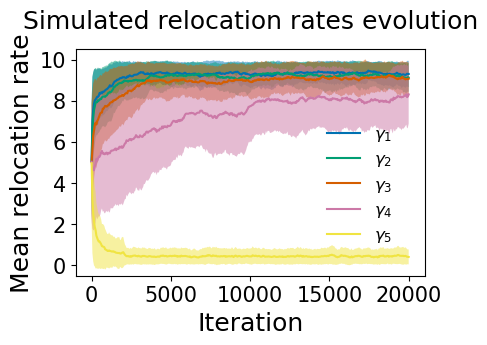

In [6]:
#################### Requires original data to be save in './evolve_data/' ####################
# visualize the results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import string
style.use('seaborn-colorblind')

data_path='./evolve_data/standard_params_20_trials_20000_iterations' # data folder path
number_of_trials=20
with open(data_path+"/trial_0/resource.txt", "rb") as fp:   # Unpickling
    resource = pickle.load(fp)
iteration = 20001
iter_interval = 50 # save_iter in the simulation
std_standard = [[] for _ in range(len(range(0, iteration, iter_interval)))]
ave_standard = [[] for _ in range(len(range(0, iteration, iter_interval)))]
for i in range(0, iteration, iter_interval):
    data = [[] for _ in range(number_of_trials)]

    boxdata = []
    for j in range(number_of_trials):
        try:
            with open(data_path+"/trial_{}/iteration_{}".format(j, i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.array([data[j][i].hop for i in range(500)]))
    std_standard[int(i/iter_interval)] = np.std(np.vstack(boxdata), 0)
    ave_standard[int(i/iter_interval)] = np.mean(np.vstack(boxdata), 0)

fig, axbig = plt.subplots(figsize=(4.5, 3), dpi=100)

for i in range(5):
    axbig.plot(np.linspace(0, iteration-1, int(iteration/iter_interval)+1), np.array(ave_standard)[
               :, i], '-', label="$\gamma_{}$".format(i+1))
    axbig.fill_between(np.linspace(0, iteration-1, int(iteration/iter_interval)+1), np.array(ave_standard)[
                       :, i]-np.array(std_standard)[:, i], np.array(ave_standard)[:, i]+np.array(std_standard)[:, i], alpha=0.5)
axbig.set_ylabel('Mean relocation rate', fontsize=18)
axbig.set_xlabel('Iteration', fontsize=18)
axbig.set_title('Simulated relocation rates evolution', fontsize=18, pad=15)
axbig.legend(loc='lower right', bbox_to_anchor=(
    0.95, 0.07), frameon=False, fontsize=12)
axbig.set_ylim(-0.5, 10.5)
axbig.set_yticks([0, 2, 4, 6, 8, 10])
axbig.tick_params(axis='x', labelsize=15)
axbig.tick_params(axis='y', labelsize=15)

Text(0.5, -0.1, 'Phenotype component')

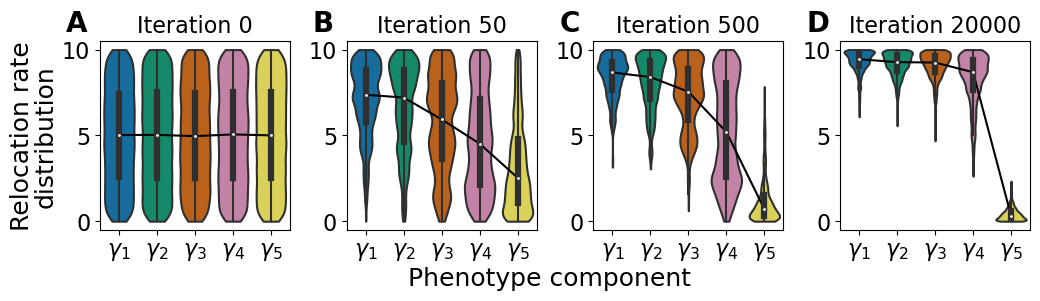

In [7]:
#################### Requires original data to be save in './evolve_data/' ####################
# violin plots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import string
style.use('seaborn-colorblind')

data_path='./evolve_data/standard_params_20_trials_20000_iterations'
number_of_trials=20

df = []
for i in ['00', 50, 500, 20000]:
    data = [[] for _ in range(number_of_trials)]
    boxdata = []
    for j in range(number_of_trials):
        try:
            with open(data_path+"/trial_{}/iteration_{}".format(j, i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.array([data[j][i].hop for i in range(500)]))
    df.append(pd.DataFrame(np.array(boxdata).reshape(10000, 5), columns=(
        '$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$')))


fig, ax = plt.subplots(ncols=4, nrows=1,
                       gridspec_kw=dict(width_ratios=[1, 1, 1, 1], wspace=0.3), figsize=(12, 2.5), dpi=100)

for i in range(4):
    ax[i].plot(df[i].median(), color='k', label='Simulated')
    sns.violinplot(data=df[i], scale='width', inner='box', cut=0, ax=ax[i])
    ax[i].text(-0.18, 1.05, string.ascii_uppercase[i], transform=ax[i].transAxes,
               size=20, weight='bold')
    ax[i].set_title('Iteration {}'.format(
        [0, 50, 500, 20000][i]), fontsize=16)
    ax[i].tick_params(axis='x', labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16)
fig.text(0.05, 0.5, 'Relocation rate',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.07, 0.5, 'distribution',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.5, -0.1, 'Phenotype component', fontsize=18, ha='center')

### Transition of the most competitive phenotype at different $b_5$ value and different resource level rarity

In [8]:
# 154 simulations in total, each takes around 30 mins to run for 20001 iterations; higher b5 value simulations take longer to run
# make sure to change the file name in evolve_gillespie() to  _path = './evolve_data/b5_c_plane'+'/b5_{}_c_{}'.format(birth[-1],c)+'/trial_{}'.format(trial)
# to run the simulation, change False to True in the condition below
if __name__ == '__main__' and False:
    trials_in_parallel = 20  # number of trials run in parallel
    ###Scale it down to if the number of cores available on your machine CPU is less than 20, otherwise it can run longer###
    total_iterations = 20001 # number of iterations to run
    for c in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        resource = exponetial_resource(128, 128, c)
        for b5 in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
            print(c, b5)
            with ProcessPoolExecutor() as executor:
                test = [executor.submit(evolve_gillespie, birth=[0, 1, 2, 3, b5], tot_iter=total_iterations, env_size=128, birth_noise=0.05, hop_high=10,
                                        save_data=True, trial=i, save_iter=50, agents=500, duration_iter=0.3, carrying_capacity=1, c=c, simulation_notes='For different b5 and c') for i in range(trials_in_parallel)]

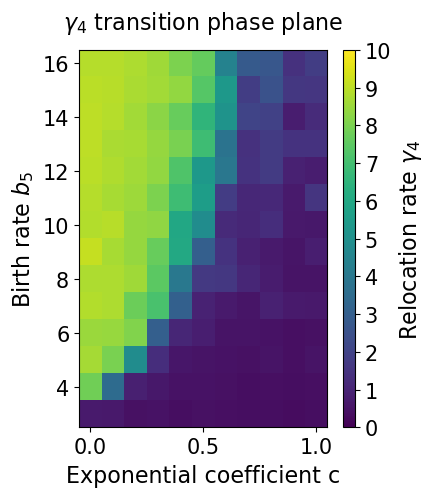

In [30]:
#################### Requires original data to be save in './evolve_data/b5_c_plane/' ####################
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import string
style.use('seaborn-colorblind')

data_path='./evolve_data/b5_c_plane'
number_of_trials=20

ave = []
for c in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for b5 in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
        boxdata = []
        for i in range(number_of_trials):
            data = [[] for _ in range(number_of_trials)]
            try:
                with open(data_path+"/b5_{}_c_{}/trial_{}/iteration_{}".format(b5, c, i, 20000), "rb") as fp:   # Unpickling
                    data[i] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j) +
                      " doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.average(
                    np.array([data[i][j].hop for j in range(500)]), axis=0))
        ave.append(np.average(np.array(boxdata).T, 1))
fig, axbig = plt.subplots(figsize=(4, 5), dpi=100)

color_mf = 'orange'
axbig.set_xlim(-0.05, 1.05)
axbig.set_ylim(2.5, 16.5)
im = axbig.imshow(np.array(ave)[:, -2].reshape(11, 14).T, interpolation='none',
                  extent=[-0.05, 1.05, 2.5, 16.5], aspect='auto', origin='lower')

axbig.set_xlabel('Exponential coefficient c', fontsize=16, labelpad=5)
axbig.set_ylabel('Birth rate $b_5$', fontsize=16, labelpad=5)

cbar = fig.colorbar(im, ticks=np.linspace(-1, 10, 12), aspect=30)
cbar.mappable.set_clim(0, 10)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Relocation rate $\gamma_4$', fontsize=16)
axbig.tick_params(axis='x', labelsize=15)
axbig.tick_params(axis='y', labelsize=15)
axbig.set_title("$\gamma_4$ transition phase plane", fontsize=16, pad=15)
plt.show()

### Agent-based stochastic simulations of the 5-state mean-field model 

In [9]:
class Agent_5_states:
    def __init__(self, h1, h2, h3, h4, h5, loc=None):
        self.hop = (h1, h2, h3, h4, h5)
        self.pos = loc
        self.b = resource[int(loc)]  # resource goes as 0, 1, 2, 3, 4, 5
        self.h = self.hop[int(loc)]
        
    def updatepos(self, loc):
        self.pos = loc
        self.b = resource[int(loc)]  # resource goes as 0, 1, 2, 3, 4, 5
        self.h = self.hop[int(loc)]


def get_i(x, arr, l, r):  # binary search for i
    if x < arr[0]:
        return 0
    else:
        while l <= r:
            mid = l + int((r - l)/2)
            # Check if x is present at mid
            if arr[mid] <= x and arr[mid+1] >= x:
                return mid+1
            # If x is greater, ignore left half
            elif arr[mid+1] <= x:
                l = mid + 1
            # If x is smaller, ignore right half
            else:
                r = mid
        # If we reach here, then the element was not present
        return -1


def noisy_hop(hop, sigma):
    rng = np.random.default_rng()
    new_hop = hop+rng.normal(0, sigma, len(hop))
    new_hop[new_hop < 0] = 0
    new_hop[new_hop > 10] = 10
    return new_hop


def evolve_5_state(T=0.3, agents=500, iterations=100, noise=0.05, prob=[0.2, 0.2, 0.2, 0.2, 0.2]):
    rng = np.random.default_rng()
    h_initial = [rng.uniform(0, 10, agents) for _ in range(5)]
    loc_initial = rng.choice([0, 1, 2, 3, 4], agents)
    a = [Agent_5_states(q, w, e, r, t, k)
         for q, w, e, r, t, k in zip(*h_initial, loc_initial)]
    hop_data = []
#     stdhop=[]
    for j in range(iterations):
        t = 0
        br = [a[i].b for i in range(len(a))]
        hr = [a[i].h for i in range(len(a))]
        brsum = sum(br)
        w = brsum + sum(hr)  # total rates

        br_cumsum = np.cumsum(br)
        hr_cumsum = np.cumsum(hr)
        while t < T:
            dt = -np.log(rng.uniform(0.0, 1.0)) / w
            t = t + dt
            r = w * rng.uniform(0.0, 1.0)

            if r < brsum:  # birth
                i = get_i(r, br_cumsum, 0, len(a)-1)
                to = rng.choice([0, 1, 2, 3, 4], p=prob)
                a.append(Agent_5_states(*noisy_hop(a[i].hop, sigma=noise), to))
                br.append(a[-1].b)
                hr.append(a[-1].h)
                brsum += a[-1].b
                w += a[-1].b+a[-1].h
                br_cumsum = np.append(br_cumsum, a[-1].b+br_cumsum[-1])
                hr_cumsum = np.append(hr_cumsum, a[-1].h+hr_cumsum[-1])
            else:  # hop
                i = get_i(r, brsum+hr_cumsum, 0, len(a)-1)
                to = rng.choice([0, 1, 2, 3, 4], p=prob)
                a[i].updatepos(to)
                brsum += a[i].b-br[i]
                w += a[i].b-br[i]+a[i].h-hr[i]
                br_cumsum[i:] += a[i].b-br[i]
                hr_cumsum[i:] += a[i].h-hr[i]
                br[i] = a[i].b
                hr[i] = a[i].h

        if len(a) > agents:
            # bring back the population back to its initial size
            reset = rng.choice(len(a), agents, replace=False)
            a = [a[i] for i in reset]
        # save the average hopping rate after each iteration
        hop_data.append(np.array([a[i].hop for i in range(len(a))]))
    return hop_data

In [10]:
from concurrent.futures import ProcessPoolExecutor
if __name__ == '__main__' and False:
    resource = [0, 1, 2, 3, 4]
    sigma = 0.05
    ave_copies = []
    with ProcessPoolExecutor() as executor:
        test = [executor.submit(evolve_5_state, agents=500,
                                iterations=701, noise=sigma) for i in range(20)]
    target = np.concatenate([test[i].result() for i in range(20)], 1)
    ave_b5_4 = np.mean(target, 1)
    std_b5_4 = np.std(target, 1)
    with open('./processed_data/fig_s_5_state_stochastic_b5_4', "wb") as fp:
        pickle.dump((ave_b5_4,std_b5_4), fp)
else:
    with open('./processed_data/fig_s_5_state_stochastic_b5_4', "rb") as fp:
        ave_b5_4,std_b5_4 = pickle.load(fp)

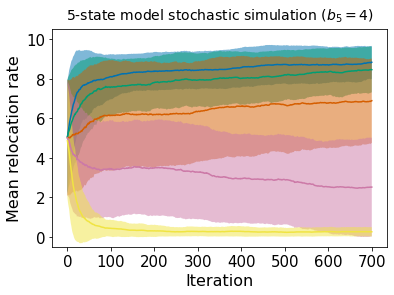

In [11]:
fig,ax=plt.subplots()
for i in range(5):
    ax.plot(range(701),ave_b5_4[:, i], label="$\gamma_{}$".format(i+1))
    ax.fill_between(range(701), np.array(ave_b5_4)[
                          :, i]-np.array(std_b5_4)[:, i], np.array(ave_b5_4)[:, i]+np.array(std_b5_4)[:, i], alpha=0.5)

ax.set_title(
    '5-state model stochastic simulation ($b_5=4$)', fontsize=14, pad=10)
ax.set_ylabel('Mean relocation rate', fontsize=16)
ax.set_xlabel('Iteration', fontsize=16)
ax.set_ylim(-0.5, 10.5)
ax.set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)

In [12]:
from concurrent.futures import ProcessPoolExecutor
if __name__ == '__main__' and False:
    resource = [0, 1, 2, 3, 5]
    sigma = 0.05
    ave_copies = []
    with ProcessPoolExecutor() as executor:
        test = [executor.submit(evolve_5_state, agents=500,
                                iterations=701, noise=sigma) for i in range(20)]
    target = np.concatenate([test[i].result() for i in range(20)], 1)
    ave_b5_5 = np.mean(target, 1)
    std_b5_5 = np.std(target, 1)
    with open('./processed_data/fig_s_5_state_stochastic_b5_5', "wb") as fp:
        pickle.dump((ave_b5_5,std_b5_5), fp)
else:
    with open('./processed_data/fig_s_5_state_stochastic_b5_5', "rb") as fp:
        ave_b5_5,std_b5_5 = pickle.load(fp)

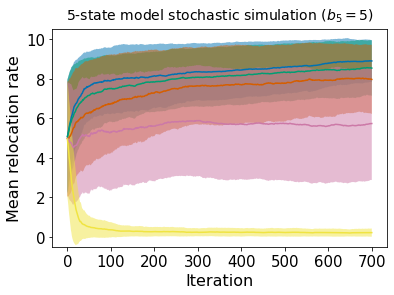

In [13]:
fig,ax=plt.subplots()
for i in range(5):
    ax.plot(range(701),ave_b5_5[:, i], label="$\gamma_{}$".format(i+1))
    ax.fill_between(range(701), np.array(ave_b5_5)[
                          :, i]-np.array(std_b5_5)[:, i], np.array(ave_b5_5)[:, i]+np.array(std_b5_5)[:, i], alpha=0.5)

ax.set_title(
    '5-state model stochastic simulation ($b_5=5$)', fontsize=14, pad=10)
ax.set_ylabel('Mean relocation rate', fontsize=16)
ax.set_xlabel('Iteration', fontsize=16)
ax.set_ylim(-0.5, 10.5)
ax.set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)